In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## 数据读取

In [2]:
import os
import os.path
import torch
import torch.nn as nn
from torch.nn.functional import softmax
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import copy

def write_txt(content, filename, mode='w'):
    """保存txt数据
    :param content:需要保存的数据,type->list
    :param filename:文件名
    """
    with open(filename, mode) as f:
        for line in content:
            str_line = ""
            for col, data in enumerate(line):
                if not col == len(line) - 1:
                    # 以空格作为分隔符
                    str_line = str_line + str(data) + " "
                else:
                    # 每行最后一个数据用换行符“\n”
                    str_line = str_line + str(data) + "\n"
            f.write(str_line)


def get_files_list(dir):
    '''
    实现遍历dir目录下,所有文件(包含子文件夹的文件)
    :param dir:指定文件夹目录
    :return:包含所有文件的列表->list
    '''
    # parent:父目录, filenames:该目录下所有文件夹,filenames:该目录下的文件名
    files_list = [] #写入文件的数据
    for parent, dirnames, filenames in os.walk(dir):
        for filename in filenames:
#             print("parent is: " + parent)
#             print("filename is: " + filename)
#             print(os.path.join(parent, filename).replace('\\','/'))  # 输出rootdir路径下所有文件（包含子文件）信息
            curr_file = parent.split(os.sep)[-1]  #获取正在遍历的文件夹名（也就是类名）
            #根据class名确定labels
            if curr_file == "bigbus":
                labels = 0
            elif curr_file == "car":
                labels = 1
            elif curr_file == "minibus":
                labels = 2
            elif curr_file == "pickup":
                labels = 3
            elif curr_file == "truckbig":
                labels = 4
            elif curr_file == "trucksmall":
                labels = 5

            dir_path = parent.replace('\\', '/').split('/')[-2]   #train?val?test?

            curr_file = os.path.join(dir_path, curr_file)  #相对路径

            files_list.append([os.path.join(curr_file, filename).replace('\\','/'), labels])	#相对路径+label


            #写入csv文件
            path = "%s" % os.path.join('../input/car-type/car_classfication/', curr_file, filename).replace('\\','/')
            label = "%d" % labels
            list = [path, label]
            data = pd.DataFrame([list])
            if dir == '../input/car-type/car_classfication/train':
                data.to_csv("./train.csv", mode='a', header=False, index=False)
            elif dir == '../input/car-type/car_classfication/val':
                data.to_csv("./val.csv", mode='a', header=False, index=False)

    return files_list

In [3]:
import pandas as pd
#先生成两个csv文件夹
df = pd.DataFrame(columns=['path', 'label'])
df.to_csv("./train.csv", index=False)

df2 = pd.DataFrame(columns=['path', 'label'])
df2.to_csv("./val.csv", index=False)

#写入txt文件
train_dir = '../input/car-type/car_classfication/train'
train_txt = './train.txt'
train_data = get_files_list(train_dir)
write_txt(train_data, train_txt, mode='w')

val_dir = '../input/car-type/car_classfication/val'
val_txt = './val.txt'
val_data = get_files_list(val_dir)
write_txt(val_data, val_txt, mode='w')

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import PIL.Image as Image
def show(img):
    if img.ndim == 2:
        plt.imshow(img,cmap="gray")
    elif img.ndim == 3:
        plt.imshow(img)
    plt.show()

In [5]:
train_df = pd.read_csv("./train.csv")
val_df = pd.read_csv("./val.csv")
train_df.head()

,path,label
0,../input/car-type/car_classfication/train/truc...,4
1,../input/car-type/car_classfication/train/truc...,4
2,../input/car-type/car_classfication/train/truc...,4
3,../input/car-type/car_classfication/train/truc...,4
4,../input/car-type/car_classfication/train/truc...,4


## 创建数据集

In [6]:
# 图像增广
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [7]:
data_dir = "../input/car-type/car_classfication"
batch_size = 4
train_ds = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_ds = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_ds, batch_size, shuffle=False)

In [8]:
for X, y in train_loader:
    print(X.shape)
    print(y)
    break

torch.Size([4, 3, 224, 224])
tensor([2, 2, 3, 5])


In [9]:
# for X, y in test_loader:
#     print(X.shape)
#     print(y)

In [10]:
# 预训练模型 ResNet-18 
net = torchvision.models.resnet18(pretrained=True)
classes = ["bigbus", "car", "minibus", "pickup", "truckbig", "trucksmall"]
num_classes = len(classes)
# 更改输出层
net.fc = nn.Linear(512, num_classes)
print(net)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 测试函数

In [11]:
def evaluation(net, test_data, test_loader):
    net.eval()
    eval_loss = 0.
    eval_acc = 0.
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = net(X)
            _, preds = torch.max(outputs, 1)
            l = loss(outputs, y)
            eval_loss += l.item() * X.size(0)
            num_correct = torch.sum(preds == y.data)
            eval_acc += num_correct
        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
                test_data)), eval_acc / (len(test_data))))
    return eval_loss/len(test_data), eval_acc/len(test_data)

## 训练函数

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

net.to(device)
# 超参数
lr = 1e-4
num_epochs = 20
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 指数衰减  ---以指数衰减,gamma代表指数函数的底数---
ExpLR = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

loss = nn.CrossEntropyLoss()
history = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}
print("---------without training----------")
# train_loss, train_acc = evaluation(net, train_ds, train_loader)
test_loss, test_acc = evaluation(net, val_ds, test_loader)
print("-----------------------------------")


print("training on", device)
for epoch in range(num_epochs):
    print('epoch {}'.format(epoch + 1))
    # training-----------------------------
    net.train()
    train_loss = 0.
    train_acc = 0.
    
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        outputs = net(X)
        _, preds = torch.max(outputs, 1)
        l = loss(outputs, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        with torch.no_grad():
            train_loss += l.item() * X.size(0)
            num_correct = torch.sum(preds == y.data)
            train_acc += num_correct
            
    train_loss, train_acc = train_loss/len(train_ds), train_acc/len(train_ds)
    test_loss, test_acc = evaluation(net, val_ds, test_loader)
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss, train_acc))
   
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc.cpu())
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc.cpu())

---------without training----------
Test Loss: 1.915639, Acc: 0.138614
-----------------------------------
training on cuda
epoch 1
Test Loss: 0.055593, Acc: 1.000000
Train Loss: 0.415143, Acc: 0.858622
epoch 2
Test Loss: 0.019553, Acc: 1.000000
Train Loss: 0.176966, Acc: 0.948788
epoch 3
Test Loss: 0.030086, Acc: 1.000000
Train Loss: 0.113186, Acc: 0.967584
epoch 4
Test Loss: 0.043999, Acc: 0.980198
Train Loss: 0.100920, Acc: 0.971397
epoch 5
Test Loss: 0.006743, Acc: 1.000000
Train Loss: 0.076237, Acc: 0.980387
epoch 6
Test Loss: 0.067096, Acc: 0.970297
Train Loss: 0.061994, Acc: 0.986380
epoch 7
Test Loss: 0.003403, Acc: 1.000000
Train Loss: 0.075193, Acc: 0.979570
epoch 8
Test Loss: 0.005509, Acc: 1.000000
Train Loss: 0.045295, Acc: 0.988831
epoch 9
Test Loss: 0.005837, Acc: 1.000000
Train Loss: 0.046440, Acc: 0.987469
epoch 10
Test Loss: 0.004258, Acc: 1.000000
Train Loss: 0.039263, Acc: 0.990193
epoch 11
Test Loss: 0.012021, Acc: 1.000000
Train Loss: 0.051116, Acc: 0.988287
epoch

## 绘图

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(history):
    fig, ax = plt.subplots()
    fig.autofmt_xdate() 
    plt.xlabel("epochs")
    plt.ylabel("loss")
    idx = [i+1 for i in range(len(history["train_loss"]))]
    
    l1, = plt.plot(idx,history["train_loss"], color="red")
    l2, = plt.plot(idx,history["test_loss"],color="green")
    plt.legend([l1, l2],
           ['train_loss', 'test_loss'],
           loc='upper right'
    )
    plt.show()

def plot_acc(history):
    fig, ax = plt.subplots()
    plt.xlabel("epochs")
    plt.ylabel("acc")
    idx = [i+1 for i in range(len(history["train_acc"]))]
    l1, = plt.plot(idx,history["train_acc"], color="red")
    l2, = plt.plot(idx,history["test_acc"],color="green")
    plt.legend([l1, l2],
           ['train_acc', 'test_acc'],
           loc='upper right'
    )
    plt.show()

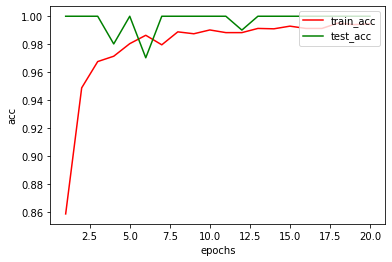

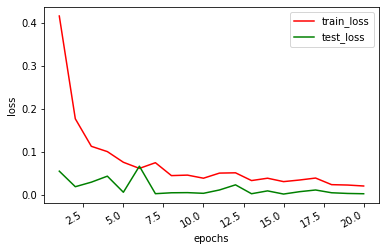

In [14]:
plot_acc(history=history)
plot_loss(history=history)